# CNN Practice: MNIST Classification

## Data Preparation

In [1]:
import torch
import torchvision
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt

print('Pytorch Version:' , torch.__version__)

Pytorch Version: 1.5.0


Training data: 

data shape:  (60000, 28, 28)
label shape:  (60000,)

Peek at some training pictures:


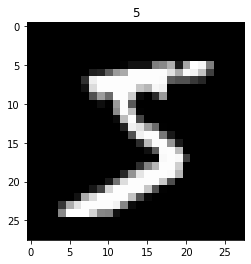

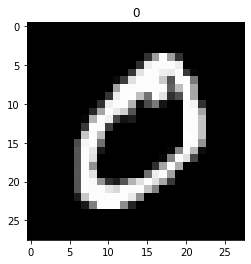

In [2]:
# hyperparameters
LR = 0.001
BATCH_SIZE = 50
EPOCH = 1
DOWNLOAD_MINIST = False

train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(), # each pixel is compressed from (0,255) to (0,1)
    download=DOWNLOAD_MINIST
)

print('Training data: \n')
print('data shape: ', train_data.data.numpy().shape)
print('label shape: ', train_data.targets.numpy().shape)

print('\nPeek at some training pictures:')
plt.imshow(train_data.data.numpy()[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

plt.imshow(train_data.data.numpy()[1], cmap='gray')
plt.title('%i' % train_data.targets[1])
plt.show()

In [3]:
test_data = torchvision.datasets.MNIST(root='./mnist',train=False)

# /255 -> compress each pixel from (0, 255) to (0,1)
test_x = Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255
test_y = test_data.targets[:2000]

print('Original test data: \n')
print('data shape: ', test_data.data.numpy().shape)
print('label size: ', test_data.targets.numpy().shape)

print('\nTest data used in this notebook: \n')
print('data shape: ', test_x.data.numpy().shape)
print('label shape: ', test_y.data.numpy().shape)

Original test data: 

data shape:  (10000, 28, 28)
label size:  (10000,)

Test data used in this notebook: 

data shape:  (2000, 1, 28, 28)
label shape:  (2000,)


In [4]:
# batched data shape: (50, 1, 28, 28)
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True
)

## Build CNN

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d( # apply 2D convolution
                in_channels=1, # 28x28 black and white images, which only contain 1 channel
                out_channels=16, # 16 filters to extract 16 features
                kernel_size=5, # 5x5 filter
                stride=1,
                padding=2, # to maintain spatial size, padding = (kernel_size-stride)/2
            ), # -> (16, 28, 28)
            torch.nn.ReLU(), # -> (16, 28, 28)
            torch.nn.MaxPool2d(kernel_size=2) # -> (16, 14, 14)
        ) 
        
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2), # -> (32, 14, 14)
            torch.nn.ReLU(), # -> (32, 14, 14)
            torch.nn.MaxPool2d(2) # -> (32, 7, 7)
        )
        
        self.score = torch.nn.Linear(32*7*7, 10) # we have 10 labels from 0 to 9
        
    def forward(self, x):
        x = self.conv1(x) # -> (batch, 32, 14, 14)
        x = self.conv2(x) # -> (batch, 32, 7, 7)
        x = x.view(x.size(0), -1) # -> (batch, 32*7*7)
        scores = self.score(x) # -> (batch, 10)
        return scores

In [6]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (score): Linear(in_features=1568, out_features=10, bias=True)
)


## Training & Testing

In [7]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

# training and testing
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
        
        scores = cnn(batch_x)
        loss = loss_fn(scores, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 60000 input images, batch_size = 50
        # there are 60000/50 = 1200 steps
        if step % 100 == 0: 
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.3016 | test accuracy: 0.15
Epoch:  0 | train loss: 0.2184 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2552 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3305 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1592 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0903 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1107 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0418 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1005 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0608 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0744 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0582 | test accuracy: 0.98


## Prediction

In [8]:
# print 10 predictions from test data
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print('prediction: ', pred_y)
print('true label: ', test_y[:10].numpy())

prediction:  [7 2 1 0 4 1 4 9 5 9]
true label:  [7 2 1 0 4 1 4 9 5 9]
